In [8]:
pip install --no-cache-dir horovod

     |████████████████████████████████| 3.5 MB 1.8 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for horovod: filename=horovod-0.28.1-cp37-cp37m-linux_x86_64.whl size=16362224 sha256=8a30a51133c998ecdac925d948c8535c1245d49330b349d1c30bcf63f6bdf329
  Stored in directory: /tmp/pip-ephem-wheel-cache-cooadwoe/wheels/75/bf/bf/1131c00d74352837272d3a176b5c32ed602a4010137cbbbd72
Successfully built horovod
Note: you may need to restart the kernel to use updated packages.


In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
import requests

from ectutorial.data import SlidingWindowDataset, get_ett_dataset
from ectutorial.gen_models import TCNGANModule
from ectutorial.plot import plot_pair_fake_val, plot_risk
from ectutorial.wcr import calculate_worst_case_risk
from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator
from fdd_defense.attacks import FGSMAttack, PGDAttack, DeepfoolLinfAttack, NoiseAttack
from fdd_defense.models.base import BaseTorchModel
from fdd_defense.models import MLP
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [2]:
dataset = FDDDataset(name='small_tep')
dataset.df.head()

Reading data/small_tep/test_mask.csv: 100%|██████████| 153300/153300 [00:00<00:00, 1280103.05it/s]


xmeas_1  xmeas_2  xmeas_3  xmeas_4  xmeas_5  xmeas_6  \
run_id    sample                                                         
413402073 1       0.25038   3674.0   4529.0   9.2320   26.889   42.402   
          2       0.25109   3659.4   4556.6   9.4264   26.721   42.576   
          3       0.25038   3660.3   4477.8   9.4426   26.875   42.070   
          4       0.24977   3661.3   4512.1   9.4776   26.758   42.063   
          5       0.29405   3679.0   4497.0   9.3381   26.889   42.650   

                  xmeas_7  xmeas_8  xmeas_9  xmeas_10  ...   xmv_2   xmv_3  \
run_id    sample                                       ...                   
413402073 1        2704.3   74.863   120.41   0.33818  ...  53.744  24.657   
          2        2705.0   75.000   120.41   0.33620  ...  53.414  24.588   
          3        2706.2   74.771   120.42   0.33563  ...  54.357  24.666   
          4        2707.2   75.224   120.39   0.33553  ...  53.946  24.725   
          5        2705.1   75.388   120.39   0.32632  ...  53.658  28.797   

                   xmv_4   xmv_5   xmv_6   xmv_7   xmv_8   xmv_9  xmv_10  \
run_id    sample                                                           
413402073 1       62.544  22.137  39.935  42.323  47.757  47.510  41.258   
          2       59.259  22.084  40.176  38.554  43.692  47.427  41.359   
          3       61.275  22.380  40.244  38.990  46.699  47.468  41.199   
          4       59.856  22.277  40.257  38.072  47.541  47.658  41.643   
          5       60.717  21.947  39.144  41.955  47.645  47.346  41.507   

                  xmv_11  
run_id    sample          
413402073 1       18.447  
          2       17.194  
          3       20.530  
          4       18.089  
          5       18.461  

[5 rows x 52 columns]

In [3]:
scaler = StandardScaler()
scaler.fit(dataset.df[dataset.train_mask])
dataset.df[:] = scaler.transform(dataset.df)

In [4]:
dataset.df.head()

xmeas_1   xmeas_2   xmeas_3   xmeas_4   xmeas_5   xmeas_6  \
run_id    sample                                                               
413402073 1      -0.089143  0.264405  0.236224 -0.401718 -0.065059  0.161746   
          2      -0.084244 -0.097819  0.500445  0.224017 -0.789993  0.760022   
          3      -0.089143 -0.075490 -0.253925  0.276162 -0.125470 -0.979790   
          4      -0.093352 -0.050680  0.074436  0.388820 -0.630335 -1.003859   
          5       0.212176  0.388454 -0.070119 -0.060203 -0.065059  1.014461   

                   xmeas_7   xmeas_8   xmeas_9  xmeas_10  ...     xmv_2  \
run_id    sample                                          ...             
413402073 1      -0.205368 -0.052990  0.137588 -0.095616  ... -0.066463   
          2      -0.195283  0.061410  0.137588 -0.119259  ... -0.162221   
          3      -0.177996 -0.129814  0.278441 -0.126065  ...  0.111416   
          4      -0.163589  0.248459 -0.144118 -0.127259  ... -0.007847   
          5      -0.193843  0.385406 -0.144118 -0.237233  ... -0.091418   

                     xmv_3     xmv_4     xmv_5     xmv_6     xmv_7     xmv_8  \
run_id    sample                                                               
413402073 1      -0.289009 -0.057907  0.002977 -0.024498  1.415088  0.538157   
          2      -0.292479 -0.549265 -0.003867 -0.004712  0.150295 -1.176649   
          3      -0.288557 -0.247719  0.034353  0.000871  0.296607  0.091844   
          4      -0.285590 -0.459968  0.021053  0.001938 -0.011453  0.447038   
          5      -0.080814 -0.331183 -0.021556 -0.089439  1.291595  0.490910   

                     xmv_9    xmv_10    xmv_11  
run_id    sample                                
413402073 1      -0.175181 -0.126519 -0.029363  
          2      -0.180156 -0.116522 -0.308372  
          3      -0.177699 -0.132359  0.434464  
          4      -0.166310 -0.088411 -0.109080  
          5      -0.185012 -0.101873 -0.026246  

[5 rows x 52 columns]

In [8]:
len(dataset.df.index)

153300

In [755]:
gan = TCNGANModule.load_from_checkpoint(
    checkpoint_path='chk_29.07.ckpt',
    latent_dim=8,
    target_dim=len(dataset.df.columns),
    hidden_dim=256,
    num_layers=4,
    lr=0.00240
)

In [756]:
seq_len = 10
fake = gan.sample(seq_len, temp=0.1)

### Defense GAN

In [768]:
R = 1000
z = torch.randn(R, seq_len, 8)
z.requires_grad = True

In [769]:
window_size = 10
test_loader = FDDDataloader(
    dataframe=dataset.df,
    mask=dataset.test_mask,
    labels=dataset.labels,
    window_size=window_size,
    step_size=1,
)

Creating sequence of samples: 100%|██████████| 105/105 [00:00<00:00, 703.46it/s]


In [770]:
for batch, _, _ in test_loader:
    break
sample = batch[[0]]
sample = torch.FloatTensor(sample)
sample.shape

torch.Size([1, 10, 52])

In [771]:
optim = Adam([z], lr=0.1)

In [772]:
from tqdm.auto import trange

In [773]:
gan.to('cuda');
z = z.to('cuda')
sample = sample.to('cuda')

In [774]:
for i in trange(100):
    
    fake = gan.gen(z)[..., 0]
    loss = torch.mean((sample - fake)**2)
    optim.zero_grad()
    loss.backward()
    optim.step()

  0%|          | 0/100 [00:00<?, ?it/s]

In [788]:
upd_fake = gan.gen(z)[..., 0]


In [789]:

best_id = torch.min(
    ((sample - upd_fake)**2).mean(dim=(1, 2))
)


In [790]:
a=[]
for i in range(1000):
    a.append(np.mean((upd_fake[i].detach().cpu().numpy()[:,1] - sample.cpu().numpy()[0, :,1])**2))
best_id_i=np.array(a).argmin()

In [791]:
print(best_id, best_id_i)

tensor(0.2569, device='cuda:0', grad_fn=<MinBackward1>) 792


решил вручную перепроверить аргмин, а он наебал

In [793]:
best_fake = upd_fake[best_id_i]

In [794]:
best_fake.shape

torch.Size([10, 52])

In [795]:
#plt.plot(upd_fake[0].detach().cpu().numpy()[:, 1]);

In [796]:
#plt.plot(best_fake.detach().cpu().numpy()[:, 1]);

In [797]:
#plt.plot(sample.cpu().numpy()[0, :, 1]);

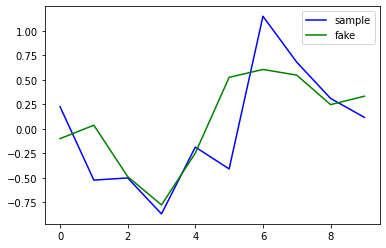

In [798]:
plt.plot(sample.cpu().numpy()[0, :, 1],'b-',best_fake.detach().cpu().numpy()[:, 1],'g-');
plt.legend(['sample','fake']);

In [799]:
np.mean((best_fake.detach().cpu().numpy()[:, 1] - sample.cpu().numpy()[0, :, 1])**2)

0.16692969

# upd_fake[0] иногда лучше best_fake